# Dropping a ball
Written by Tim Atherton for Computational Physics 
January 16, 2020

This program aims to simulate the motion of a ball dropped from an initial height of $y0$ under gravity $g$ using the Euler discretization.

## Import libraries for plotting and numerical work

In [1]:
import sys
print(sys.version)

3.7.6 (default, Dec 30 2019, 19:38:26) 
[Clang 11.0.0 (clang-1100.0.33.16)]


In [20]:
import matplotlib.pyplot as plt
import numpy as np

## Set up parameters for the calculation

In [21]:
g=10 #Gravity constant in (metres per second sq.)

y0=0 #Initial Height (in metres) Positive means upwards
v0=0 #Initial Velocity (in metres per second)
t0=0 #Initial Time (in s)

dt=0.1 #Time resolution
tf=10 #Total time to simulate

nsteps=int(tf/dt)+1 #note that we take the integer part

## Create arrays for time, velocity and position

In [22]:
t = np.linspace(t0,tf,nsteps)
v = np.zeros([nsteps])
y = np.zeros([nsteps])

## Main loop, where we successively update velocity and time according to the Euler rule

In [23]:
y[0]=y0
v[0]=v0
for i in range(1,nsteps):
    v[i]=v[i-1]+0.1
    y[i]=y[i-1]+v[i]*dt

## Visualize the result

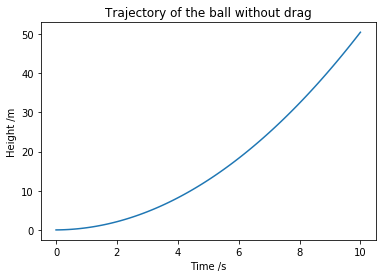

In [25]:

plt.plot(t,y)
plt.title('Trajectory of the ball without drag')
plt.xlabel('Time /s')
plt.ylabel('Height /m')
plt.show()